In [8]:
import os
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

# Dataset

In [10]:
import numpy as np

class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

In [3]:
X = np.random.randint(0,high=2, size=10*2).reshape((10, 2))
y = np.logical_xor(X[:,0], X[:,1]).astype(np.uint)
print(X)
print(y)
print(X[2])
print(y[2])

[[0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [1 0]]
[0 1 0 0 1 0 0 1 1 1]
[0 0]
0


In [4]:
ds_train = XORDataset(200)
ds_val= XORDataset(50)
ds_test = XORDataset(30)

In [5]:
ds_train[3]


(array([1., 0.], dtype=float32), array([1.], dtype=float32))

# Dataloaders

In [6]:
# Prepare training data loader

# how many samples per batch to load
batch_size=40
train_batch_size = batch_size
valid_batch_size = batch_size
test_batch_size = batch_size

loaders = {
    'train' : torch.utils.data.DataLoader(ds_train,  
                                          batch_size=train_batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(ds_val, 
                                          batch_size=valid_batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(ds_test, 
                                          batch_size=test_batch_size , 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7faac06ec910>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7faac06ece50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa95bb5fe80>}

In [11]:
def get_data(batch_size):

    datasets = {
        'train' : XORDataset(200),
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model

In [12]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
        self.layers = nn.Sequential(
            self.linear, 
            self.Sigmoid, 
            self.linear2
        )
        # custom weight initialization
        nnLinearLayers = [layer for layer in self.layers if type(layer) == nn.Linear]
        for layer in nnLinearLayers:
            nn.init.normal_(layer.weight)

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [13]:
def get_model(lr):
    model = XORnet()

    # optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.03) 
    return model, optimizer

In [14]:
loss_fn = nn.MSELoss() 

In [1]:
# to do : determine learning rate by grid search
'''To make comparisons easier, we use the
same learning rate η for FF+FB and FF, determined by grid search. 
We average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of
epochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest
number of epochs of the two networks that reached 100% training accuracy in 10 runs.'''

'To make comparisons easier, we use the\nsame learning rate η for FF+FB and FF, determined by grid search. '

In [10]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/xor_experiment_1')
dataiter = iter(loaders['train'])
Xs, ys = dataiter.next()
print('Xs:', Xs)
writer.add_graph(model, Xs, verbose=True)


Xs: tensor([[1., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 1.],
        [1., 0.],
        [0., 0.],
        [1., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [1., 0.],
        [0., 1.],
        [0., 0.]])
graph(%self.1 : __torch__.XORnet,
      %x : Float(40, 2, strides=[2, 1], requires_grad=0, device=cpu)):
  %73 : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="layers"](%self.1)
  %60 : __torch__.torch.nn.modules.linear.___torch_mangle_0.Linear = prim:

In [41]:
class statsLogger():
    def __init__(self):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):
        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        minibatch_accuracy = minibatch_num_corrects.item()/pred.shape[0]
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        self.accuracies.append(100 * self.epoch_correct_samples / self.epoch_total_samples)
        
    

In [49]:
epochs=100
epoch_training_accuracies=[]
epoch_valid_accuracies=[]
epoch_training_losses=[]
epoch_valid_losses=[]

def process_batch(model, loss_func, xb, yb, opt=None):
    pred = model(xb)
    loss = loss_func(pred, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return pred, loss.item(), len(xb)

def fit(model, optimizer, loaders, epochs):

    trainLogger = statsLogger()
    validLogger = statsLogger()

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        train_loss, valid_loss = [], []
        train_epoch_total = 0
        train_epoch_correct = 0
        valid_epoch_total = 0
        valid_epoch_correct = 0
        valid_accuracy = []

        ## training part 
        ##--------------
        model.train()
        for xb, yb in loaders['train']:

            optimizer.zero_grad()


            ## 1. forward propagation
            pred = model(xb)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            train_loss.append(loss.item())

            # tensorboard
            # writer.add_scalar("Loss/train", loss, epoch)
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)


            #Accuracy
            predicted = (pred>0.5).float()
            minibatch_num_corrects = (predicted == yb).float().sum()
            minibatch_total = pred.shape[0]
            minibatch_accuracy = minibatch_num_corrects.item()/pred.shape[0]
            train_epoch_total += minibatch_total
            train_epoch_correct += minibatch_num_corrects.item()

            # print("Epoch {}/{}, Training Loss: {:.3f}, Training Minibatch Accuracy: {:.3f}".format(epoch+1,epochs, loss.item(), minibatch_accuracy))
        epoch_training_losses.append(np.array(train_loss).mean())
        trainLogger.endEpoch()
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)
                valid_loss.append(loss.item())
                
                #Accuracy
                prediction = (pred>0.5).float()
                valid_minibatch_num_corrects = (prediction == yb).float().sum()
                valid_minibatch_total = pred.shape[0]
                valid_minibatch_accuracy = valid_minibatch_num_corrects.item()/pred.shape[0]

                # print("Epoch {}/{}, Valid Loss: {:.3f}, Valid Minibatch Accuracy: {:.3f}".format(epoch+1,epochs, loss.item(), minibatch_accuracy))

                valid_accuracy.append(valid_minibatch_accuracy)
                valid_epoch_total += valid_minibatch_total
                valid_epoch_correct += valid_minibatch_num_corrects.item()

                validLogger.getMinibatchStats(pred, yb, loss)

            epoch_valid_losses.append(np.array(valid_loss).mean())
            validLogger.endEpoch()

        # epoch statistics

        epoch_training_accuracy = 100 * train_epoch_correct / train_epoch_total
        epoch_valid_accuracy = 100 * valid_epoch_correct / valid_epoch_total
        epoch_training_accuracies.append(epoch_training_accuracy )
        epoch_valid_accuracies.append(epoch_valid_accuracy)

        average_validation_accuracy=np.mean(valid_accuracy)
        print("Epoch:", epoch+1, "Training Loss:", np.mean(train_loss),"Valid Loss: ", np.mean(valid_loss), "Valid accuracy: ", np.mean(valid_accuracy))
        print("Training accuracy:", epoch_training_accuracy , ", Valid accuracy:", epoch_valid_accuracy)
        #if average_validation_accuracy == 1:
        #   break

        # writer.flush()
    return { 'train' : trainLogger, 'valid' : validLogger }


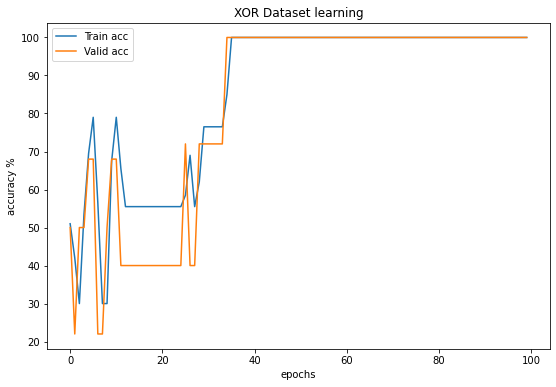

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(epoch_training_accuracies, label='Train acc')
axs.plot(epoch_valid_accuracies, label='Valid acc')
axs.set_title('XOR Dataset learning')
axs.set_xlabel('epochs')
axs.set_ylabel('accuracy %')
plt.legend()
plt.show()

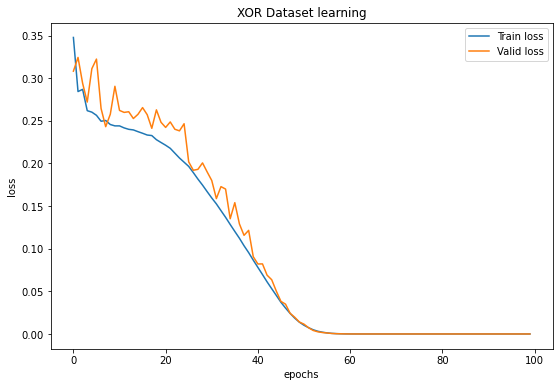

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(epoch_training_losses, label='Train loss')
axs.plot(epoch_valid_losses, label='Valid loss')
axs.set_title('XOR Dataset learning')
axs.set_xlabel('epochs')
axs.set_ylabel('loss')
plt.legend()
plt.show()

In [50]:
lr = 0.03
bs=40
datasets, loaders = get_data(bs)
model, opt = get_model(lr)

epochs=100
loggers = fit(model, opt, loaders, epochs)

Epoch: 1 Training Loss: 0.3477199852466583 Valid Loss:  0.30821408331394196 Valid accuracy:  0.5
Training accuracy: 51.0 , Valid accuracy: 50.0
Epoch: 2 Training Loss: 0.28428431153297423 Valid Loss:  0.32431361079216003 Valid accuracy:  0.175
Training accuracy: 42.0 , Valid accuracy: 22.0
Epoch: 3 Training Loss: 0.2868566393852234 Valid Loss:  0.29396580159664154 Valid accuracy:  0.5375
Training accuracy: 30.0 , Valid accuracy: 50.0
Epoch: 4 Training Loss: 0.2618708312511444 Valid Loss:  0.27195873856544495 Valid accuracy:  0.5
Training accuracy: 53.5 , Valid accuracy: 50.0
Epoch: 5 Training Loss: 0.2601488709449768 Valid Loss:  0.31110499799251556 Valid accuracy:  0.6499999999999999
Training accuracy: 69.5 , Valid accuracy: 68.0
Epoch: 6 Training Loss: 0.2564286768436432 Valid Loss:  0.3223614990711212 Valid accuracy:  0.5375
Training accuracy: 79.0 , Valid accuracy: 68.0
Epoch: 7 Training Loss: 0.24947212934494017 Valid Loss:  0.2644239813089371 Valid accuracy:  0.21250000000000002


In [46]:
type(loggers['train'].losses)
type(loggers['train'].losses[0])

numpy.float64

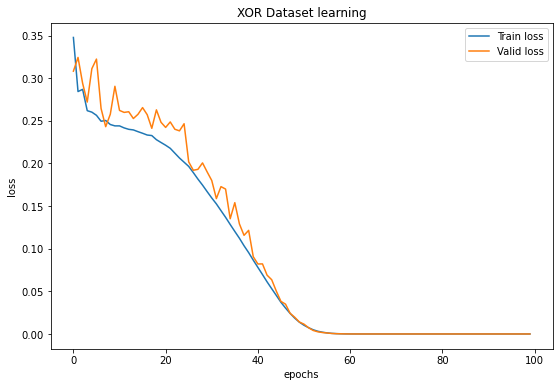

In [51]:
fig, axs= plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(loggers['train'].losses, label='Train loss')
axs.plot(loggers['valid'].losses, label='Valid loss')
axs.set_title('XOR Dataset learning')
axs.set_xlabel('epochs')
axs.set_ylabel('loss')
plt.legend()
plt.show()

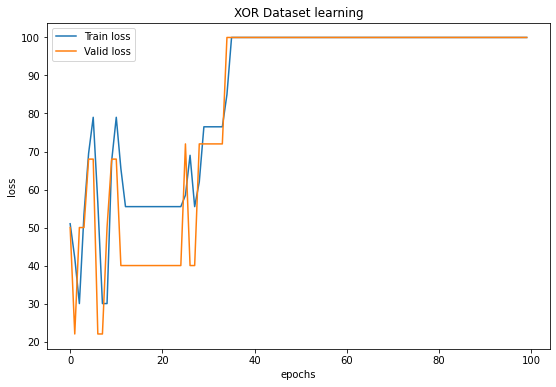

In [54]:
fig, axs= plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(loggers['train'].accuracies, label='Train loss')
axs.plot(loggers['valid'].accuracies, label='Valid loss')
axs.set_title('XOR Dataset learning')
axs.set_xlabel('epochs')
axs.set_ylabel('loss')
plt.legend()
plt.show()